In [1]:
# Before we begin, let's set up some configurations
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.formatters import PlainTextFormatter
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
PlainTextFormatter.max_seq_length = 10

# Python Modeling of Schelling's Segregation Model Using Mesa

## Introduction

The [Schelling's model of segregation](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation) is an agent-based model reported by Thomas Schelling in 1978.  The Schelling model shows how segregation can arise naturally even in areas where all individuals' personal preferences desire a more integrated system.  In other words, the macro-level effects of choices made at the individual level are often unexpected.  This model is presented in Week 1 of [the Coursera course, *Model Thinking*, by Professor Scott Page.](https://www.coursera.org/learn/model-thinking/home/welcome)

In the Schelling Model a residential area (i.e. city) is modeled as an NxN square grid.  Each square on the grid represents a residence where an individual may choose to live.  Individuals seek to live in residences where at least some fraction of individuals are "similar to them" -- perhaps by race, income, political party, or primary language spoken.  

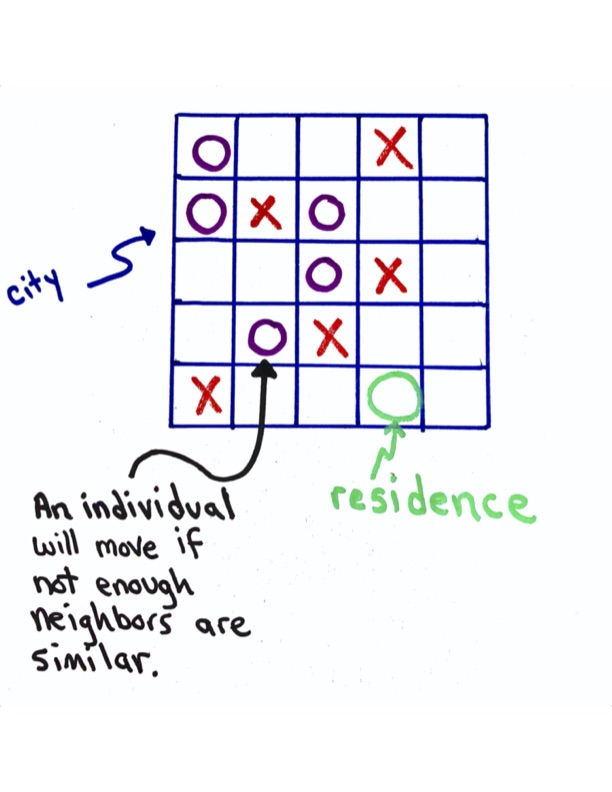

The model is iterative, proceeding by steps.  Initially individuals (agents in the model) are placed randomly in squares on the grid.  Then for each step as the model is run, if the fraction of neighbors that are similar to that individual does not meet or exceed the individual's threshold for similarity, the individual moves to another random location on the grid. 


## The Model

This notebook uses the agent-based modeling package, [Mesa](https://mesa.readthedocs.io/en/master/), to implement the model and run the simulation.  To set up the model we define the `NeighborAgent` class, inheriting from `mesa.Agent`, and the `NeighborhoodModel` class, inheriting from `mesa.Model`.  Implementation using Mesa is straightforward.  We need only provide initialization methods to set up the model and agents and `step` methods to specify what happens at each iteration of the model.   

### Model Definition


In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid

from numpy.random import rand


class NeighborAgent(Agent):
    """ An neighbor agent for the NeighborhoodModel 
    
    Attributes:
        category     Integer representing the agent's category (i.e. race) 
        thresh       Minimum fractional value of neighbors that individual would like to be in same category
        similarity   (derived) Fractional value of neighbors that are in same category
        
    """
    
    def __init__(self, unique_id, model,thresh,category):
        """ Initialize NeighborAgent """
        super().__init__(unique_id, model)
        self.thresh=thresh
        self.category=category
        
    def step(self):
        # If similarity of neighbors is less than thresh then move
        if self.similarity < self.thresh:
            self.move()
    
    @property
    def similarity(self):
        """ Fraction of neighbors (including diagonals) that have the same category as agent.  If a neighbor space is empty, do not count it in the tally."""
        neighbors = self.model.grid.get_neighbors(self.pos,moore=True,include_center=False,radius=1)
        similarity=1 # If no neighbors, then similarity is 1.  (Avoids divide by zero error.)
        if len(neighbors)>0:
            similarity = sum([x.category == self.category for x in neighbors])/len(neighbors)
        return similarity
    
    def move(self):
        self.model.grid.move_to_empty(self)
        
    def __repr__(self):
        return("NeighborAgent:\n\tID:{uid},\n\tCategory:{category},\n\tThresh:{thresh},\n\tPosition:{pos},\n\tSimilariy:{similarity}\n".format(
            uid=self.unique_id,category=self.category,thresh=self.thresh,pos=self.pos,similarity=self.similarity))
    
    
class NeighborhoodModel(Model):
    """ Implementation of Schelling's Segregation Model """
    
    def __init__(self,agents_per_category:list,thresh:float,width:int,height:int):
        """Initialize and return a NeighborhoodModel
        
        Parameters
        ----------
           agents_per_category:  list
               list of integers such that the jth element is the number of agents with category j
            
            thresh: float
                fractional value of neighbors that each agent in model requires to be in same category
            
            width: int
                width of model grid
                
            height: int
                height of model grid
               
            
        """
        super().__init__()
        self.num_agents = sum(agents_per_category)
        self.grid = SingleGrid(width, height, False)  # Note that grid is not toroidal -- boundries don't wrap
        self.schedule = RandomActivation(self)
        # Create agents
        for category, n_agents in enumerate(agents_per_category):
            for idx in range(0,n_agents):
                a = NeighborAgent(self.next_id(), self, thresh, category)
                self.schedule.add(a)
                self.grid.position_agent(a,'random','random') # Place the agent to a random, unoccupied grid cell

    def step(self):
        """Advance the model by one step"""
        self.schedule.step()
    
    @property
    def nagents(self):
        return sum(self.agents_per_category)
    
    def __repr__(self):
        return("NeighborhoodModel:\n\tNumber of Agents:{nagents},\n\tGrid Size:{width}X{height}\n".format(
            nagents=len(self.schedule.agents),width=self.grid.width,height=self.grid.height))
    


### Model Initialization and Attributes

To initialize `NeighborhoodModel` we need to specify some aspects of our model:

* `agents_per_category`: A list that specifies the number of individuals assigned to category.  For example, for a model with 10 individuals of one race, 5 of another race, and 7 of a third race, we would input the list [10,5,7].  The total number of individuals in the model is just the sum of the elements of `agents_per_category`.<br><br>
* `thresh`: A threshold value that specifies the individuals' preferences for fractional number of similar neighbors.  That is, it's the fraction of neighbors that must be in the same category as the individual for the individual to want to remain in the same residence at each step.  Note that in this model, every agent is assigned the same threshold value.<br><br>
* `width` and `height`:  These are the width and the height of the model grid.<br><br>

Note that in the `NeighborAgent` model we have defined one additional dependent attribute:  `similarity`.  This is the computed fraction percent of the individual's neighbors that fall in the same category as that individual.

In [3]:
#Initialize the model
my_model = NeighborhoodModel([10,10,10],.5,10,10)

NeighborhoodModel:
	Number of Agents:30,
	Grid Size:10X10

In [4]:
# Select the first agent from the model
agent0 = my_model.schedule.agents[0]

NeighborAgent:
	ID:1,
	Category:0,
	Thresh:0.5,
	Position:(1, 7),
	Similariy:0.0

In [5]:
# Get the positions and categories of each agent
agent_positions_and_categories = [((x.pos),x.category) for x in my_model.schedule.agents]

[((1, 7), 0),
 ((8, 1), 0),
 ((4, 1), 0),
 ((3, 6), 0),
 ((4, 6), 0),
 ((7, 1), 0),
 ((3, 9), 0),
 ((2, 4), 0),
 ((9, 8), 0),
 ((8, 7), 0),
 ...]

## Running and Visualizing the Model

We can now run the model and ask 
1. What is the mean level of "similarity" that each agent experiences in their living situation.  That is, what is the average value for the percentage of similar neighbors?
2. What is the average level of happiness for individuals in the model?  That is, what fraction of the individuals  have at least `thresh` neighbors that are similar to them?

### Mean similarity and unhappiness

To address these questions, let's define two functions on the `NeighborhoodModel`.
* `mean_similarity` is the average value of `similarity` taken over all the agents in the model.
* `mean_unhappiness` is the fraction of agents that are not living with a number of similar neighbors at or above their threshold value.

In [6]:
import numpy as np

def mean_similarity(model):
    """ Return the average similarity taken over all agents in model """
    return np.mean([x.similarity for x in model.schedule.agents])
    

def mean_unhappiness(model):
    """ Return the fration of agents with similarity below thresh"""
    return sum([x.similarity<x.thresh for x in model.schedule.agents])/model.schedule.get_agent_count()

mean_similarity(my_model)

0.3472222222222222

In [7]:
mean_unhappiness(my_model)

0.5666666666666667

### Visualization Code

We'll now create visualization routines to display the model as it runs.  We will show an image of the model grid.  The placement of agents on the grid will be show with the color indicating the agent's category.  We'll also plot `mean_similarity` and `mean_unhappiness` over time to show how the values change as we step through the model.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import time

%matplotlib notebook

In [9]:
def plot_grid(ax,model):
    categories = np.zeros((model.grid.width,model.grid.height))-1
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        if cell_content:
            categories[x][y]=cell_content.category
    ax.imshow(categories)

def plot_similarity(ax,similarities):
    ax.plot(range(len(similarities)),similarities)

def plot_unhappiness(ax,unhappinesses):
    ax.plot(range(len(unhappinesses)),unhappinesses)

def visualize_model(model,nsteps):
    """ Run and visualize NeighborhoodModel 
    
    Parameters:
    -----------
    model: NeighborhoodModel
        The NeighborhoodModel to run and visualize
    
    nsteps: int
        The number of iterations to run the model
    """
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2,2)
    
    im_ax = fig.add_subplot(gs[:,0])
    
    unhappiness_ax = fig.add_subplot(gs[0,1])
    unhappiness_ax.set_xlim(0,nsteps)
    unhappiness_ax.set_ylim(0,1)
    unhappiness_ax.set_title("Mean Unhappiness")
    
    similarity_ax = fig.add_subplot(gs[1,1])
    similarity_ax.set_xlim(0,nsteps)
    similarity_ax.set_ylim(0,1)
    similarity_ax.set_title("Mean Similarity")
    
    similarities = []
    unhappinesses = []

    for idx in range(nsteps):
        model.step()
        similarities.append(mean_similarity(model))
        unhappinesses.append(mean_unhappiness(model))
        plot_grid(im_ax,model)
        plot_similarity(similarity_ax,similarities)
        plot_unhappiness(unhappiness_ax,unhappinesses)
        im_ax.set_title("Iteration={}".format(idx))
        fig.canvas.draw()
        time.sleep(.2)

### Low Preference Model

Now we're ready to run some models and visualize the results.  We'll run two different models.  Both will have three categories of agent, but the similarity preference thresholds will be different.  We'll start with a "low preference model", in which individuals preference for having similar neighbors is relatively low at 30%.

<IPython.core.display.Javascript object>


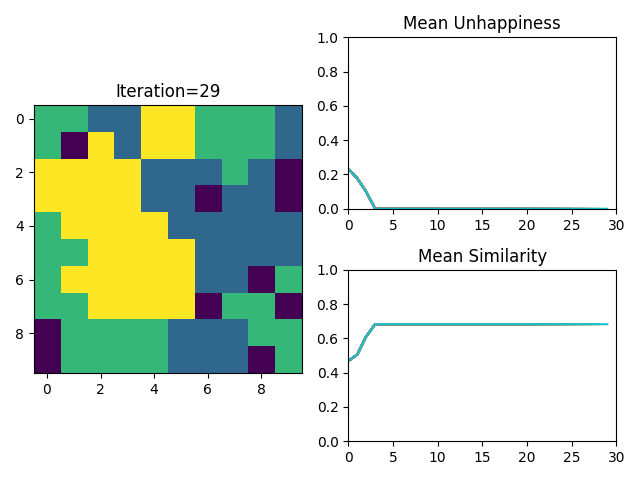

In [10]:
# Model with low preference for similarity
nsteps = 15

low_preference_model = NeighborhoodModel([30,30,30],.3,10,10)
# As long as you have 30% (or 3/8 if no unoccupied spaces) you are happy
# Or if one empty next to you then you need only 2 similar to you
visualize_model(low_preference_model,30)

In [11]:
# mean similarity after running model
mean_similarity(low_preference_model)

0.6827248677248677

Note that in this case the model converges to a steady state relatively quickly (exactly how many steps will depend on the random seed that your simulation started with).  The mean unhappiness level attained a low value, but the mean similarity was rather high -- much higher in fact than the individual preference for similarity.

### High Preference Model

In the high preference model the only change is that individuals now require 70% or greater of their neighbors to be similar.  Let's see what happens...

<IPython.core.display.Javascript object>


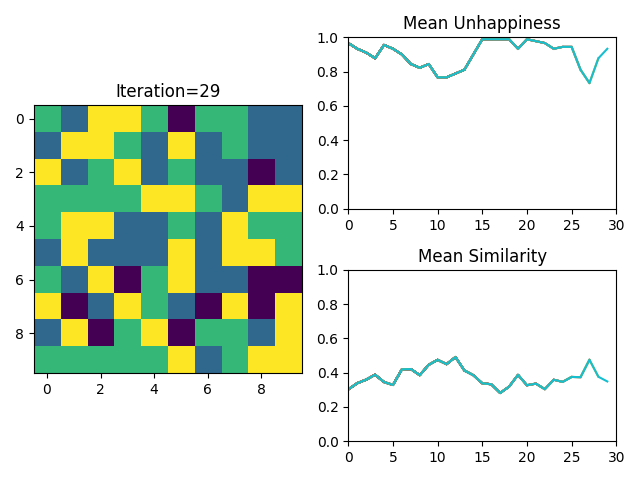

In [12]:
high_preference_model = NeighborhoodModel([30,30,30],.7,10,10)
# For all surrounding spaces occupied need 6/8 similiar to you.
visualize_model(high_preference_model,30)

With this one simple change of *increasing* the individual preference threshold value for similarity, we find that the actual mean value of similarity is decreased compared to the low preference model.  Furthermore, people in this model are more unhappy.

This is the irony of Schelling's Segregation Model.  When individual preference for segregation is low, a steady state solution to the model can easily be found but it is likely to be one in which the overall level of segregation is higher than individuals would prefer.  When the individual preference for segregation is high, a steady state solution is difficult to find.  Agents move about much more in the model, the mean similarity is lower than in the low preference case, and mean unhappiness is much higher. 